In [1]:
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from string import punctuation
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from nltk.corpus import wordnet as wn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns

<p style="font-family:Muro;font-weight:bold;font-size:55px;margin:50px 0px 50px 0px;color:#ADD8E6;text-align: center">Sentiment Analysis</p>

In [2]:
script_path = "Data/the-office-lines-script.xlsx"
df_dialog = pd.read_excel(script_path, index_col = "id")

In [3]:
df_dialog

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False
...,...,...,...,...,...,...
59905,9,23,112,It all seems so very arbitrary. I applied for ...,Creed,False
59906,9,23,113,I just feel lucky that I got a chance to share...,Meredith,False
59907,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis,False


In [4]:
# We remove the parenthetical. That is, the text into parenthesis that provides directions for the characters.
parentheticals_regex = r"(\[.*?\])"

def remove_parentheticals(line):
    line = str(line)
    parentheticals = re.findall(parentheticals_regex,line)
    
    for parenthetical in parentheticals:
        line = line.replace(parenthetical, "")
    
    return line

In [5]:
def get_character_lines_per_episode(character):

    df_aired_lines = df_dialog.loc[df_dialog.deleted == False]
    df_character = df_aired_lines.loc[df_aired_lines.speaker == character]
    
    character_season_lines = {}

    for season in df_character.season.unique():
        df_season = df_character.loc[df_character.season == season]
        character_episode_lines = {}
        
        for episode in df_season.episode.unique():
            df_episode = df_season.loc[df_season.episode == episode]
        
            character_episode_lines[episode] = [remove_parentheticals(line) for line in list(df_episode.line_text)]
        
        character_season_lines[season] = character_episode_lines
        
    return character_season_lines

In [6]:
def get_character_lines_per_season(character):
    character_season_lines = get_character_lines_per_episode(character)       
    return {season:[line for episode in episodes.values() for line in episode] for (season, episodes) in character_season_lines.items()}

In [7]:
def get_character_lines_series(character):  
    dialog = get_character_lines_per_season(character)
    return [line for season in dialog.values() for line in season]

In [8]:
def un_pack_episode_lines(character):
    episode_lines = get_character_lines_per_episode(character)   
    return {(season,episode):lines for (season,episodes) in episode_lines.items() for (episode,lines) in episodes.items()}
    #return [lines for episode in episode_lines.values() for lines in episode.values()]

In [9]:
df_aired = df_dialog[df_dialog.deleted == False]
characters_dialog = df_aired.speaker.unique()

In [54]:
def get_avg_sentiment_node_VADER(character, avg = True):
    analyzer = SentimentIntensityAnalyzer()
    #character = character.split("_")[0]
    
    total = []

    # otherwise, for each sentence in the character's dialogue
    dialogue = get_character_lines_series(character)
    for sentence in dialogue:
        # compute the polarity score
        vs = analyzer.polarity_scores(sentence)
        total.append(vs["compound"])
    
    if not avg:
        return total
    # return the average sentiment across all sentences in the character's dialogue
    return sum(total)/len(dialogue)

In [55]:
char_sentiment_VADER = {char:get_avg_sentiment_node_VADER(char) for char in characters_dialog}
# sort sentiment
#char_sentiment_VADER = dict(sorted(char_sentiment_VADER.items(), key=lambda item: item[1], reverse = True))

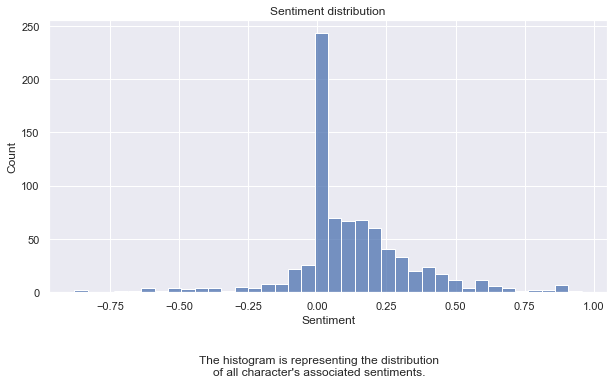

<Figure size 432x288 with 0 Axes>

In [56]:
sns.set_theme()
title = "Sentiment distribution"
caption = "The histogram is representing the distribution\nof all character's associated sentiments."
plt.figure(figsize=[10,5])
sns.histplot(char_sentiment_VADER)
plt.title(title)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
plt.savefig("images/sentiment_distribution.png")

In [57]:
df_filepath = "Data/dataframe_characters.csv"
df = pd.read_csv(df_filepath)
main_characters = list(df[df.Category == "Main_Characters"]["Unnamed: 0"])
main_characters = [character.split(" ")[0] for character in main_characters]

In [70]:
data = {character:get_avg_sentiment_node_VADER(character, avg = False) for character in main_characters}
max_len = max([len(x) for x in data.values()])

for key in data.keys():
    data[key] += [None]*(max_len-len(data[key]))
    
data = pd.DataFrame(data)

<AxesSubplot:>

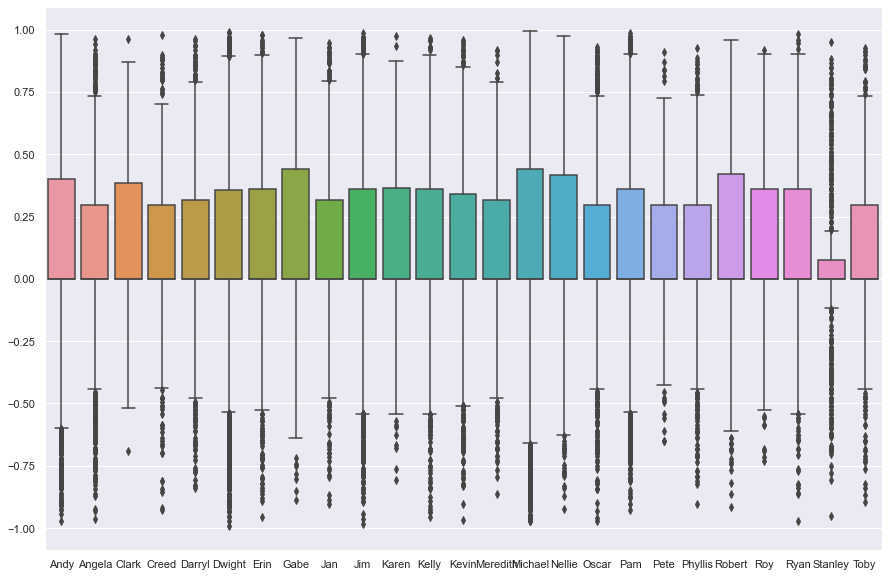

In [73]:
plt.figure(figsize=[15,10])
sns.boxplot(data=data)

C:\Users\blanc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


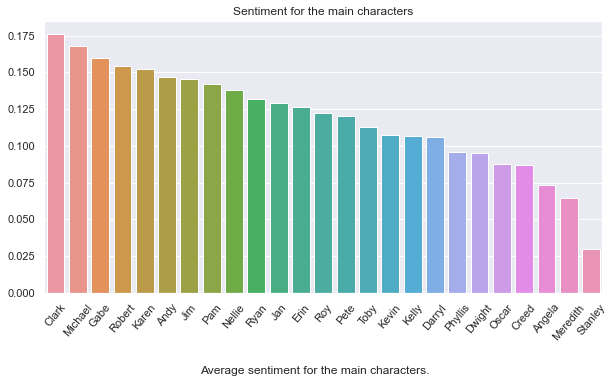

<Figure size 432x288 with 0 Axes>

In [29]:
title = "Sentiment for the main characters"
caption = "Average sentiment for the main characters."
plt.figure(figsize=[10,5])
main_char_sentiments = {char:char_sentiment_VADER[char] for char in main_characters}
main_char_sentiments = dict(sorted(main_char_sentiments.items(), key=lambda item: item[1], reverse = True))
x = list(main_char_sentiments.keys())
y = list(main_char_sentiments.values())
sns.barplot(x,y)
plt.title(title)
plt.xticks(rotation=50)
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
plt.savefig("images/sentiment_per_character.png")

In [31]:
def get_sentiment_season(character):
    season_lines = get_character_lines_per_season(character)    
    total_per_seasons = []
    stds = []
    
    for season in range(1,10):
        
        if season not in season_lines.keys():
                total_per_seasons.append(None)
                stds.append(None)
        else:
            lines = season_lines[season]
            total = []
            analyzer = SentimentIntensityAnalyzer()       

            for sentence in lines:
                # compute the polarity score
                vs = analyzer.polarity_scores(sentence)
                total.append(vs["compound"])
            total_per_seasons.append(sum(total)/len(lines))
            stds.append(np.std(total))
            
    return {"sentiment": total_per_seasons, "std":stds}

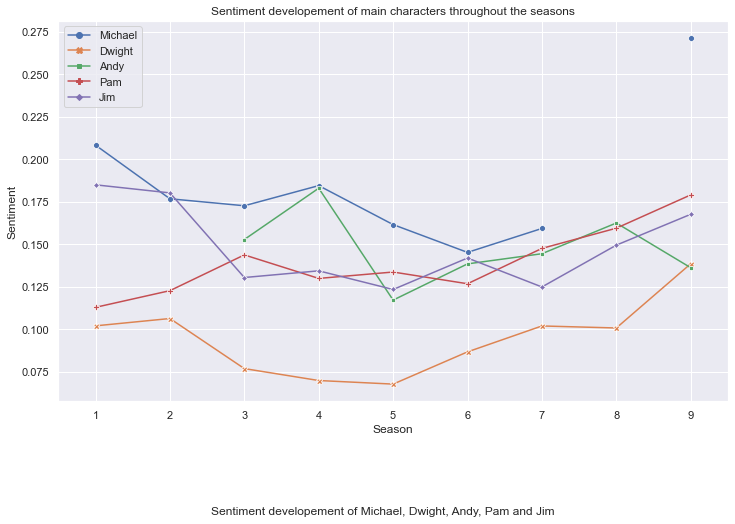

In [32]:
characters_sentiment = ["Michael", "Dwight", "Andy", "Pam", "Jim"]
sentiments = {character:get_sentiment_season(character) for character in characters_sentiment}
data = pd.DataFrame({character:sentiments[character]["sentiment"] for character in characters_sentiment}, index = list(range(1,10)))
title = "Sentiment developement of main characters throughout the seasons"
caption = "Sentiment developement of Michael, Dwight, Andy, Pam and Jim"
plt.figure(figsize=[12,7])
sns.lineplot(data=data, markers=True, dashes=False)
plt.xlim(0.5,9.5)
plt.xlabel('Season')
plt.ylabel('Sentiment')
plt.title(title)
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
#plt.errorbar('Time', 'Latency', x=data., yerr=[x["std"] for x in sentiments.values()])
plt.show()

'\nsns.lineplot(ax=axes[1][1], x = range(n), y = get_sentiment_episode("Andy"))\naxes[1][1].set_title("Sentiment for Andy per every episode")\n\nsns.lineplot(ax=axes[1][2], x = range(n), y = get_sentiment_episode("Angela"))\naxes[1][2].set_title("Sentiment for Agela per every episode")\n'

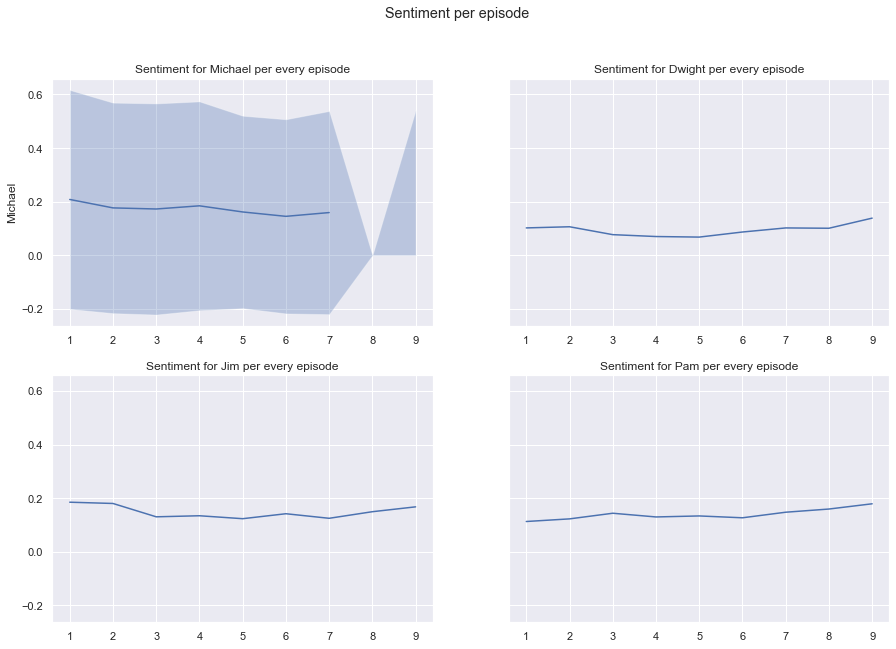

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
fig.suptitle('Sentiment per episode')
x = range(1,10)

data = pd.DataFrame({character:sentiments[character]["sentiment"] for character in characters_sentiment}, index = list(range(1,10)))
c = sentiments["Michael"]["sentiment"]
std = sentiments["Michael"]["std"]
std_min = [ci-stdi if ci != None else 0 for (ci,stdi) in zip(c,std)]
std_max = [ci+stdi if ci != None else 0 for (ci,stdi) in zip(c,std)]

sns.lineplot(ax=axes[0][0], data=data["Michael"])
axes[0][0].fill_between(x, std_min, std_max , alpha = 0.3)
axes[0][0].set_title("Sentiment for Michael per every episode")

sns.lineplot(ax=axes[0][1], x = x, y = sentiments["Dwight"]["sentiment"])
axes[0][1].set_title("Sentiment for Dwight per every episode")

sns.lineplot(ax=axes[1][0], x = x, y = sentiments["Jim"]["sentiment"])
axes[1][0].set_title("Sentiment for Jim per every episode")

sns.lineplot(ax=axes[1][1], x = x, y = sentiments["Pam"]["sentiment"])
axes[1][1].set_title("Sentiment for Pam per every episode")

'''
sns.lineplot(ax=axes[1][1], x = range(n), y = get_sentiment_episode("Andy"))
axes[1][1].set_title("Sentiment for Andy per every episode")

sns.lineplot(ax=axes[1][2], x = range(n), y = get_sentiment_episode("Angela"))
axes[1][2].set_title("Sentiment for Agela per every episode")
'''

In [193]:
episodes = set(zip(df_dialog.season,df_dialog.episode))

In [196]:
def get_sentiment_episode(character):
    episode_lines = un_pack_episode_lines(character)   
    sentiment = []
    
    for episode in episodes:
        
        if episode not in episode_lines.keys():
                sentiment.append(None)
        else:
            lines = episode_lines[episode]
            total = []
            analyzer = SentimentIntensityAnalyzer()       

            for sentence in lines:
                # compute the polarity score
                vs = analyzer.polarity_scores(sentence)
                total.append(vs["compound"])
            sentiment.append(sum(total)/len(lines))
            
    return sentiment

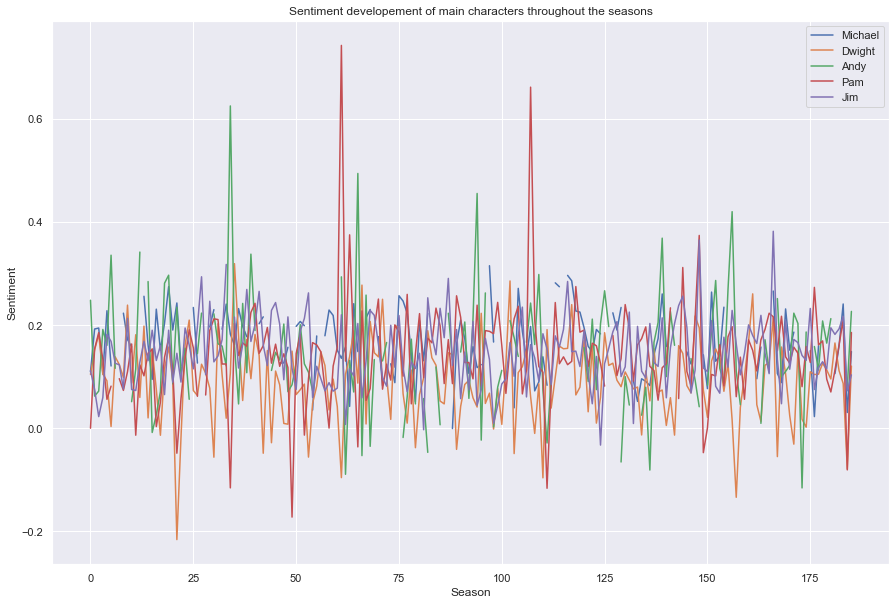

In [204]:
characters_sentiment = ["Michael", "Dwight", "Andy", "Pam", "Jim"]
sentiments = {character:get_sentiment_episode(character) for character in characters_sentiment}
data = pd.DataFrame({character:sentiments[character] for character in characters_sentiment}, index = list(range(len(episodes))))

plt.figure(figsize=[15,10])
sns.lineplot(data=data, markers=False, dashes=False)
plt.xlabel('Season')
plt.ylabel('Sentiment')
plt.title("Sentiment analysis for main characters for every episode")
plt.show()

Text(0.5, 1.0, 'Sentiment for Andy per every episode')

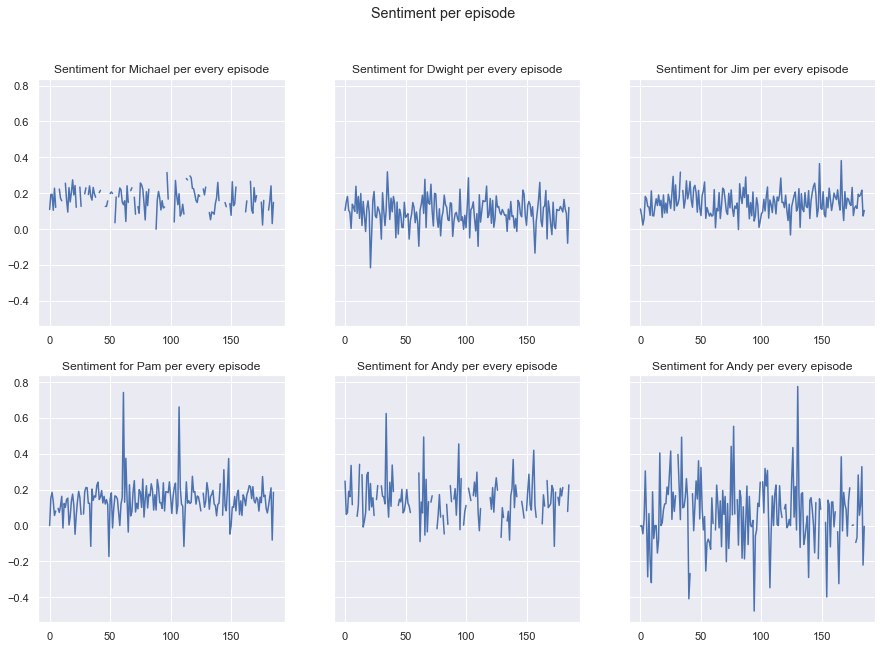

In [261]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
fig.suptitle('Sentiment per episode')
n = len(episodes)

sns.lineplot(ax=axes[0][0], x = range(n), y = get_sentiment_episode("Michael"))
axes[0][0].set_title("Sentiment for Michael per every episode")

sns.lineplot(ax=axes[0][1], x = range(n), y = get_sentiment_episode("Dwight"))
axes[0][1].set_title("Sentiment for Dwight per every episode")

sns.lineplot(ax=axes[0][2], x = range(n), y = get_sentiment_episode("Jim"))
axes[0][2].set_title("Sentiment for Jim per every episode")

sns.lineplot(ax=axes[1][0], x = range(n), y = get_sentiment_episode("Pam"))
axes[1][0].set_title("Sentiment for Pam per every episode")

sns.lineplot(ax=axes[1][1], x = range(n), y = get_sentiment_episode("Andy"))
axes[1][1].set_title("Sentiment for Andy per every episode")

sns.lineplot(ax=axes[1][2], x = range(n), y = get_sentiment_episode("Angela"))
axes[1][2].set_title("Sentiment for Agela per every episode")

In [218]:
sentiment_by_episode = {}

for episode in episodes:
    season,ep = episode
    
    df_ep = df_dialog[(df_dialog.season == season) & (df_dialog.episode == ep)]
    lines = df_ep.line_text
    
    total = []
    analyzer = SentimentIntensityAnalyzer()       

    for sentence in list(lines):
        # compute the polarity score
        vs = analyzer.polarity_scores(str(sentence))
        total.append(vs["compound"])
        
    sentiment_by_episode[episode] = sum(total)/len(lines)   

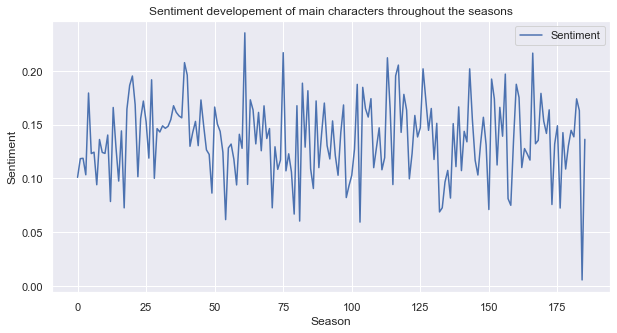

In [227]:
plt.figure(figsize=[10,5])
df = pd.DataFrame({"Episode":sentiment_by_episode.keys(), "Sentiment":sentiment_by_episode.values()})
sns.lineplot(data=df, markers=False, dashes=False)
plt.xlabel('Episode')
plt.ylabel('Sentiment')
plt.title("Average sentiment per episode")
plt.show()

In [253]:
sorted_sentiment = dict(sorted(sentiment_by_episode.items(), key=lambda item: item[1], reverse = True))
sorted_ep = list(sorted_sentiment.keys())
print(f"The saddest episode is season {sorted_ep[0][0]}, episode {sorted_ep[0][1]}: PDA")
print(f"The happiest episode is season {sorted_ep[-1][0]}, episode {sorted_ep[-1][1]}: Double Date")

The saddest episode is season 7, episode 16: PDA
The happiest episode is season 6, episode 9: Double Date


In [234]:
sentiment_by_season = defaultdict(list)

for episode in episodes:
    season,ep = episode
    
    df_ep = df_dialog[(df_dialog.season == season) & (df_dialog.episode == ep)]
    lines = df_ep.line_text
    
    total = []
    analyzer = SentimentIntensityAnalyzer()       

    for sentence in list(lines):
        # compute the polarity score
        vs = analyzer.polarity_scores(str(sentence))
        total.append(vs["compound"])
        
    sentiment_by_season[season].append(sum(total)/len(lines))

In [235]:
sentiment_season_avg = {season:sum(lst)/len(lst) for (season,lst) in sentiment_by_season.items()}

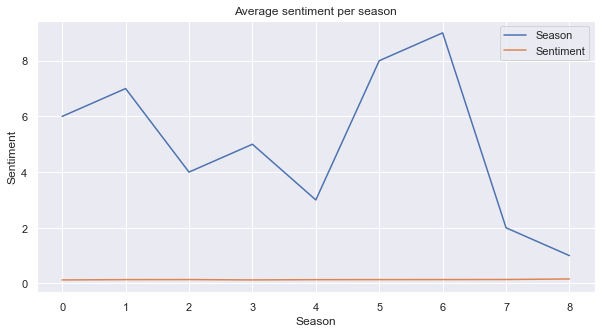

In [262]:
plt.figure(figsize=[10,5])
df = pd.DataFrame({"Season":sentiment_season_avg.keys(), "Sentiment":sentiment_season_avg.values()})
sns.lineplot(data=df, markers=False, dashes=False)
plt.xlabel('Season')
plt.ylabel('Sentiment')
plt.title("Average sentiment per season")
plt.show()